# Dataset
---



In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishmotwani/tomato")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tomato


In [2]:

train_dir = path + '/train/'
valid_dir = path + '/valid/'

## Visualisation

                                      Count
Late_blight                            3113
healthy                                3051
Septoria_leaf_spot                     2882
Bacterial_spot                         2826
Leaf_Mold                              2754
Early_blight                           2455
Tomato_mosaic_virus                    2153
Tomato_Yellow_Leaf_Curl_Virus          2039
Target_Spot                            1827
Spider_mites Two-spotted_spider_mite   1747
powdery_mildew                         1004


<Figure size 1200x600 with 0 Axes>

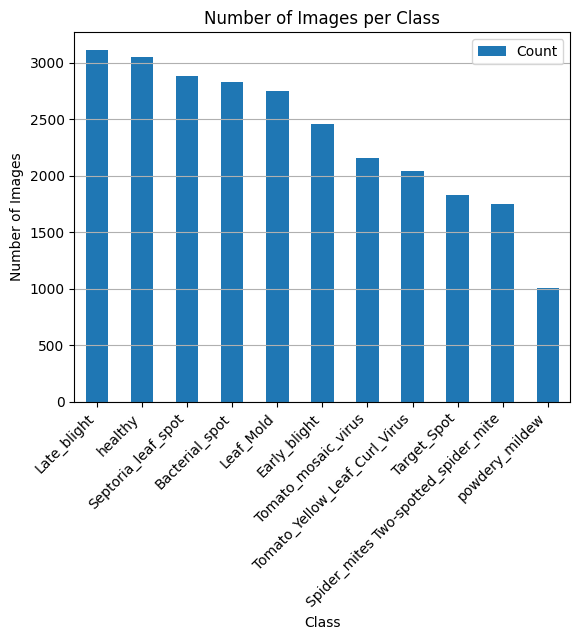

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt


# List all classes
classes = os.listdir(train_dir)

class_counts = {}

for cls in classes:
    cls_path = os.path.join(train_dir, cls)
    if os.path.isdir(cls_path):
        class_counts[cls] = len(os.listdir(cls_path))

# Convert to pandas DataFrame
class_counts_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
class_counts_df = class_counts_df.sort_values('Count', ascending=False)

print(class_counts_df)

# Plot
plt.figure(figsize=(12,6))
class_counts_df.plot(kind='bar')
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


In [ ]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Consistent size everywhere
img_height, img_width = 224, 224

# Number of images per class
num_images = 4

# Calculate how many rows you need
n_classes = len(classes)
rows = n_classes
cols = num_images

# Set overall figure size to avoid scrolling (adjust if needed)
plt.figure(figsize=(num_images * 3, n_classes * 3))  # width, height in inches

# Plot images
for idx, cls in enumerate(classes):
    cls_path = os.path.join(train_dir, cls)
    img_files = os.listdir(cls_path)
    selected_imgs = random.sample(img_files, num_images)

    for j, img_name in enumerate(selected_imgs):
        img_path = os.path.join(cls_path, img_name)
        img = image.load_img(img_path, target_size=(img_height, img_width))

        plt.subplot(rows, cols, idx * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if j == 1:  # Show class label only once per row (center image)
            plt.title(cls, fontsize=10, color='darkblue')

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setup a basic ImageDataGenerator for augmentation preview
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,          # Slightly higher rotation
    zoom_range=0.15,             # Good zoom
    horizontal_flip=True,        # Flip left-right
    vertical_flip=True,          # Flip up-down (can help sometimes)
    width_shift_range=0.1,      # More shift
    height_shift_range=0.1,           # New: Shearing transformation
    brightness_range=[0.9, 1.2], # New: Random brightness
    channel_shift_range=20.0,    # New: Slight color channel shift
    fill_mode='reflect'          # Fill empty pixels after transforms
)

# Choose any random class and image
cls_sample = random.choice(classes)
cls_path = os.path.join(train_dir, cls_sample)
img_file = random.choice(os.listdir(cls_path))
img_path = os.path.join(cls_path, img_file)

img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)

# Plot augmented images
plt.figure(figsize=(20,4))
i = 0
for batch in aug_datagen.flow(img_array, batch_size=1):
    plt.subplot(1, 5, i+1)
    plt.imshow(batch[0])
    plt.axis('off')
    if i == 4:
        break
    i += 1

plt.suptitle(f'Augmented samples of {cls_sample}', fontsize=16)
plt.show()


# ResNet50

In [3]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


In [4]:
# Train generator with augmentations
train_datagen = ImageDataGenerator(
    # rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.2],
    channel_shift_range=20.0,
    fill_mode='reflect'
)

# Validation generator (only normalization, no augmentation)
val_datagen = ImageDataGenerator(
    # rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 25851 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.


In [5]:
from tensorflow.keras.layers import Input

# Load the ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False,pooling = 'avg', input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = Dense(1024, activation='relu')(x)
x = Dropout(0.15)(x)
prediction = Dense(11, activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=prediction)

# Print model summary to verify output shape
model.summary()



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,697,163 (98.03 MB)

 Trainable params: 2,109,451 (8.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'],callbacks=[plateau])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Train the model
history=model.fit(train_generator,
                validation_data=val_generator,
                epochs=10)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 563s 678ms/step - accuracy: 0.6760 - loss: 1.0225 - val_accuracy: 0.8110 - val_loss: 0.5822
Epoch 2/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 424s 525ms/step - accuracy: 0.8417 - loss: 0.4511 - val_accuracy: 0.8715 - val_loss: 0.4001
Epoch 3/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 444s 527ms/step - accuracy: 0.8786 - loss: 0.3400 - val_accuracy: 0.8903 - val_loss: 0.3182
Epoch 4/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 419s 519ms/step - accuracy: 0.8962 - loss: 0.2930 - val_accuracy: 0.8936 - val_loss: 0.3149
Epoch 5/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 414s 512ms/step - accuracy: 0.9081 - loss: 0.2585 - val_accuracy: 0.9193 - val_loss: 0.2360
Epoch 6/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 415s 513ms/step - accuracy: 0.9147 - loss: 0.2415 - val_accuracy: 0.9105 - val_loss: 0.2663
Epoch 7/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 432s 534ms/step - accuracy: 0.9246 - loss: 0.2154 - val_accuracy: 0.9268 - val_loss: 0.2248
Epoch 8/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 416s 515ms/step - accuracy: 0.9272 -

In [7]:
from google.colab import drive
drive.mount('/content/drive')
model_save_path = '/content/drive/My Drive/resnet50_v2.h5'
model.save(model_save_path)


Mounted at /content/drive


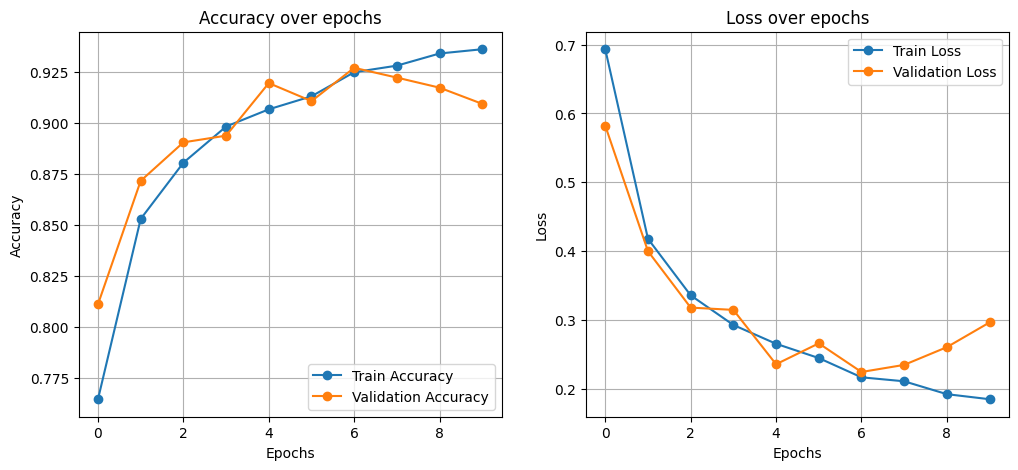

In [8]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
# Scores is just a list containing loss and accuracy value # VGG19
scores=model.evaluate(train_generator)
scores2=model.evaluate(val_generator)
print("Training Loss is :"+str(scores[0]))
print("Training Accuracy is :"+str(scores[1]*100)+" %")
print("Testing Loss is : "+str(scores2[0]))
print("Testing Accuracy is : "+str(scores2[1]*100)+" %")

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict the labels
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # for multi-class classification

# True labels
y_true = val_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
class_labels = list(val_generator.class_indices.keys())
# Display confusion matrix with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)  # Rotating x labels a bit
plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)